# Question 107 - Customer recency
Data Analysis Python Pandas Data Manipulation External Dataset

On a scale of 1-3, with 1 being least valuable and 3 being most valuable, 
can you classify customers based on recency of last purchase? 
For example, a purchase made 1 month ago is more valuable than one made 5 months ago,
so the former customer would have a higher recency score than the latter. 
You can download the data here (link missing - using [here instead](https://www.kaggle.com/vijayuv/onlineretail))

For more information regarding customer lifetime value, 
you can read [this post](https://www.shopify.com/blog/customer-lifetime-value) from Shopify's blog.

The solution will be provided to premium subscribers in Python. 
Note that this question is a part of a series of questions which will build off of each other.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as spstats
import seaborn as sns

raw_df = pd.read_csv(
    'q107_data.csv', 
    encoding='ISO-8859-1', 
    parse_dates=['InvoiceDate']
)
raw_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
# clean up and build main dataset
raw_df['dt'] = raw_df['InvoiceDate'].dt.date
raw_df['spend'] = raw_df['Quantity'] * raw_df['UnitPrice']
daily_user_spend_df = (
    raw_df
    .dropna()
    .query('spend>0')
    .groupby(['CustomerID','dt'])
    .agg({'spend':'sum'})
    .reset_index()
    .rename({'CustomerID':'cid'},axis='columns')
)
daily_user_spend_df['cid'] = daily_user_spend_df['cid'].astype('int64')
daily_user_spend_df.head()

,cid,dt,spend
0,12346,2011-01-18,77183.60
1,12347,2010-12-07,711.79
2,12347,2011-01-26,475.39
3,12347,2011-04-07,636.25
4,12347,2011-06-09,382.52


Timeframe is 2010-12-01 to 2011-12-09


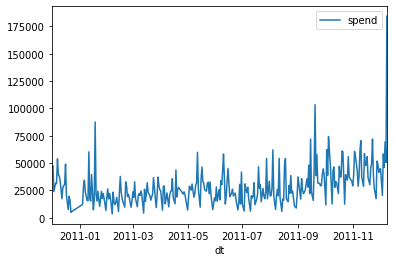

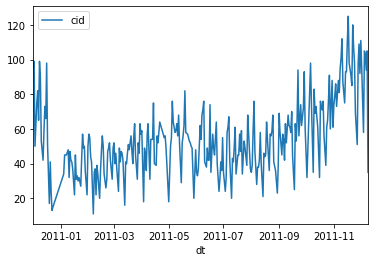

In [3]:
start_dt, end_dt = daily_user_spend_df['dt'].min(), daily_user_spend_df['dt'].max()
print(f'Timeframe is {start_dt} to {end_dt}')

daily_user_spend_df.groupby('dt').agg({'spend':'sum'}).plot()
daily_user_spend_df.groupby('dt').agg({'cid':'count'}).plot()

In [4]:
# timeframe = [start_dt, end_dt]
start_dt, end_dt = daily_user_spend_df['dt'].min(), daily_user_spend_df['dt'].max()
span_days = (end_dt - start_dt).days # https://stackoverflow.com/a/45039811

# rec: recency in [0,1]. 0 means last seen on end_dt, 1 last seen on start_dt. 
# freq: frequency in [0,1]. number of days seen during period / period length
# spend: total spend over whole period
rfm_users_df = daily_user_spend_df.groupby('cid').agg({'dt':['max','count'],'spend':'sum'})
rfm_users_df.columns = ['last_dt','freq','spend'] # change column names
# could use ["_".join(x) for x in df.columns.ravel()] instead
rfm_users_df['freq'] = rfm_users_df['freq'] / span_days # in (0,1], 0 is rare
# could divide freq by customer lifespan instead
rfm_users_df['rec'] = (end_dt - rfm_users_df['last_dt']).dt.days / (span_days+1) # in [0,1), 0 is recent
# span_days+1 so a user who showed up only on 2010-12-01 scores <1
rfm_users_df.drop(['last_dt'], axis='columns', inplace=True)
rfm_users_df.head()


,freq,spend,rec
cid,,,
12346,0.002681,77183.60,0.868984
12347,0.018767,4310.00,0.005348
12348,0.010724,1797.24,0.200535
12349,0.002681,1757.55,0.048128
12350,0.002681,334.40,0.828877


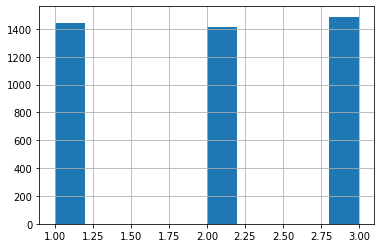

In [5]:
# option 1: recency_score = quantile.
rfm_users_df['rec_score_1'] = pd.qcut(rfm_users_df['rec'],3,labels=[3,2,1]) # 3 means recent
rfm_users_df['rec_score_1'].hist()

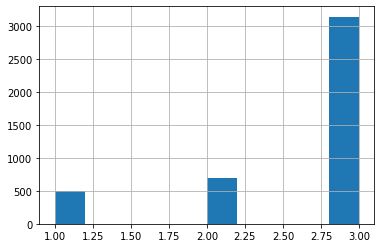

In [6]:
# option 2: recency_score = rank of bin, when binning into 3 even segments of recency
rfm_users_df['rec_score_2'] = pd.cut(rfm_users_df['rec'],3,labels=[3,2,1]) # 3 means recent
rfm_users_df['rec_score_2'].hist()

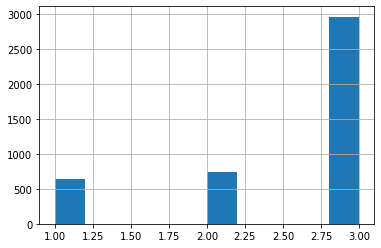

In [7]:
# option 3: recency_score = round( 3 * (2^(1-rec)-1) ). 
# rationale: 1-rec so 0 means ancient, 1 means recent
# 2^x-1 makes a 1-day difference between recencies of 1d and 2d bigger, 
# and between 90d and 91d negligible.
# 2^x-1 is valid because it's a bijection from [0,1] to [0,1]
rfm_users_df['rec_score_3'] = np.ceil(3* (2**(1-rfm_users_df['rec'])-1))
rfm_users_df['rec_score_3'].hist()


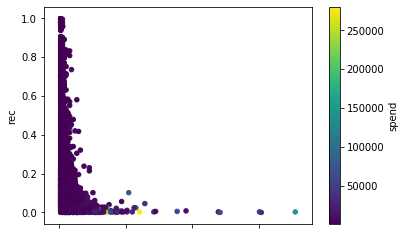

In [8]:
# freq vs rec scatter
rfm_users_df.plot.scatter(x='freq',y='rec',c='spend',colormap='viridis')